**Whats your ten-twenty?**

#### Positional Encoding 

Transformer architectures process input sequences in parallel and do not inherently know the order of tokens (unlike RNNs or CNNs). To address this limitation, positional encoding is introduced. Positional Encoding injects information about token position into the input embeddings, allowing the model to understand the order and relative positions.

To add positional information to the input tokens, we add a positional encoding matrix to the input embedding matrix i.e. same positional encoding information is added to entire embedding (d_model). 

**Why this is important?**

- Without positional encoding, the model treats the input tokens as a bag of words — no order.
- Order is critical for language, time series, and any sequential data.
- Positional encodings provide a way to represent positions as vectors that can be combined with token embeddings.

Fig: A simple integer based positional encoding technique. 

![Positional Encoding](media/pe.jpg)


**Variations**
1. Integer positional encodings 
2. Boolean Positional encodings 
3. Sinusoidal positional encodings.
5. Learned positional encodings.
6. Rotary positional embeddings.
7. Relative positional encodings.
8. Alibi (Attention with Linear Biases).
9. Convolutional Positional Encoding.
10. Fourier Positional Encoding.


In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from utils import plot_sin_cos

torch.manual_seed(42)

**Integer Positional Encodings**

It assigns each position in the sequence an integer index (e.g., 0, 1, 2, 3...). The model uses these indices as inputs, often embedded via a lookup table similar to word embeddings. Below is a simple example. 

In [14]:
batch_size = 1
seq_len = 3
d_model = 3

# Random token embeddings
tokens = torch.randn(batch_size, seq_len, d_model)  # [B, S, D]
print(f"tokens:\n{tokens}\n")
# Integer positions 0,1,... seq_len-1
pos_indices = torch.arange(seq_len).unsqueeze(0).expand(batch_size, seq_len) # [B, S]
# this is optional at this point but can be useful for other types of embeddings
pos_scaled = pos_indices.float() #/ seq_len  # scale to [0,1]

print(f"Pos idx shape:{pos_indices.shape}\npos idx:{pos_indices}\n")

# Expand positional info to match embedding dims (e.g., repeat or linear proj)
pos_feature = pos_scaled.unsqueeze(2).expand(-1, -1, d_model)  # [B, S, D]
print(f"Pos feture shape:{pos_feature.shape}\n{pos_feature}\n")

# # Combine token embeddings + integer positional info (simple addition)
x = tokens + pos_feature

for i in range(seq_len):
    print(f'[{i}] Original token:{tokens[0,i]}\npos encoding values{pos_feature[0,i]}\nAfter PE:{x[0,i]}\n')


tokens:
tensor([[[ 0.3367,  0.1288,  0.2345],
         [ 0.2303, -1.1229, -0.1863],
         [ 2.2082, -0.6380,  0.4617]]])

Pos idx shape:torch.Size([1, 3])
pos idx:tensor([[0, 1, 2]])

Pos feture shape:torch.Size([1, 3, 3])
tensor([[[0., 0., 0.],
         [1., 1., 1.],
         [2., 2., 2.]]])

[0] Original token:tensor([0.3367, 0.1288, 0.2345])
pos encoding valuestensor([0., 0., 0.])
After PE:tensor([0.3367, 0.1288, 0.2345])

[1] Original token:tensor([ 0.2303, -1.1229, -0.1863])
pos encoding valuestensor([1., 1., 1.])
After PE:tensor([ 1.2303, -0.1229,  0.8137])

[2] Original token:tensor([ 2.2082, -0.6380,  0.4617])
pos encoding valuestensor([2., 2., 2.])
After PE:tensor([4.2082, 1.3620, 2.4617])



**Boolean Positional Encodings**

It encodes position as a set of boolean flags (e.g., one-hot vectors).Each position is represented by a unique one-hot vector indicating position. For instance, we want to represent 16 tokens using binary positional encodings. 



| Index | Bits       | Index | Bits    |
|-------|---------------------------------------|-------|---------------------------------------|
| 0:    | <code style="background:#d62728; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#2ca02c; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#ff7f0e; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#1f77b4; color:#fff; padding:2px 6px; border-radius:3px;">0</code> | 8:    | <code style="background:#d62728; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#2ca02c; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#ff7f0e; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#1f77b4; color:#fff; padding:2px 6px; border-radius:3px;">0</code> |
| 1:    | <code style="background:#d62728; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#2ca02c; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#ff7f0e; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#1f77b4; color:#fff; padding:2px 6px; border-radius:3px;">0</code> | 9:    | <code style="background:#d62728; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#2ca02c; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#ff7f0e; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#1f77b4; color:#fff; padding:2px 6px; border-radius:3px;">0</code> |
| 2:    | <code style="background:#d62728; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#2ca02c; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#ff7f0e; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#1f77b4; color:#fff; padding:2px 6px; border-radius:3px;">1</code> | 10:   | <code style="background:#d62728; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#2ca02c; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#ff7f0e; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#1f77b4; color:#fff; padding:2px 6px; border-radius:3px;">1</code> |
| 3:    | <code style="background:#d62728; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#2ca02c; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#ff7f0e; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#1f77b4; color:#fff; padding:2px 6px; border-radius:3px;">1</code> | 11:   | <code style="background:#d62728; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#2ca02c; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#ff7f0e; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#1f77b4; color:#fff; padding:2px 6px; border-radius:3px;">1</code> |
| 4:    | <code style="background:#d62728; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#2ca02c; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#ff7f0e; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#1f77b4; color:#fff; padding:2px 6px; border-radius:3px;">0</code> | 12:   | <code style="background:#d62728; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#2ca02c; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#ff7f0e; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#1f77b4; color:#fff; padding:2px 6px; border-radius:3px;">0</code> |
| 5:    | <code style="background:#d62728; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#2ca02c; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#ff7f0e; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#1f77b4; color:#fff; padding:2px 6px; border-radius:3px;">0</code> | 13:   | <code style="background:#d62728; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#2ca02c; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#ff7f0e; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#1f77b4; color:#fff; padding:2px 6px; border-radius:3px;">0</code> |
| 6:    | <code style="background:#d62728; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#2ca02c; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#ff7f0e; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#1f77b4; color:#fff; padding:2px 6px; border-radius:3px;">1</code> | 14:   | <code style="background:#d62728; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#2ca02c; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#ff7f0e; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#1f77b4; color:#fff; padding:2px 6px; border-radius:3px;">1</code> |
| 7:    | <code style="background:#d62728; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#2ca02c; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#ff7f0e; color:#fff; padding:2px 6px; border-radius:3px;">0</code> <code style="background:#1f77b4; color:#fff; padding:2px 6px; border-radius:3px;">1</code> | 15:   | <code style="background:#d62728; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#2ca02c; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#ff7f0e; color:#fff; padding:2px 6px; border-radius:3px;">1</code> <code style="background:#1f77b4; color:#fff; padding:2px 6px; border-radius:3px;">1</code> |


If you look at the lest significant bit, it alternates on every number and the second lowest bit changes on every two counter. This leads learning to oscillate. In addition, for large sequence length it would be an waste of resources. 

Lets plot it. 

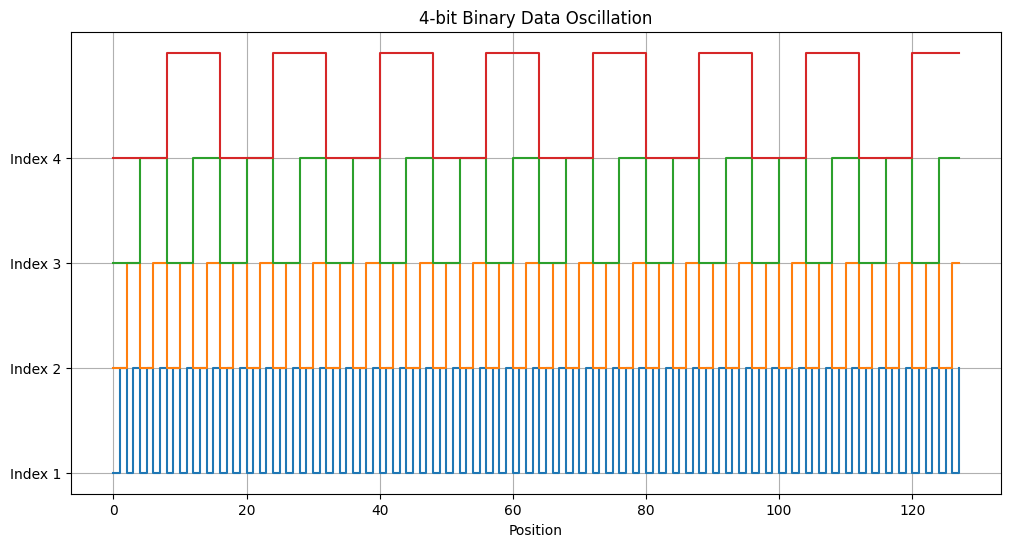

In [15]:
# number of tokens
bits = 4
# Number of data points
data_points = 128
# Create position array
x = np.arange(data_points)

# Generate binary data for each bit
data = np.array([(x >> i) & 1 for i in range(bits)])

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each bit's binary oscillation with step plot
for i in range(bits):
    ax.step(x, data[i] + i, where='post', label=f'Index {i+1}')

# Set y-ticks to label the bits' indices
ax.set_yticks(range(bits))
ax.set_yticklabels([f'Index {i+1}' for i in range(bits)])

# Add labels and grid
ax.set_xlabel('Position')
ax.set_title('4-bit Binary Data Oscillation')
ax.grid(True)

plt.show()


**Lets code Binary positional encodings (One-hot)**

In [16]:
b, seq, d_model = [2,3,4]

tokens = torch.randn(b, seq, d_model)

# one-hot vector for input tokens 
one_hot_pos = torch.eye(seq,seq) #(seq, seq)

# expand it to batch dimension 
one_hot_pos = one_hot_pos.unsqueeze(0).expand(b, -1,-1) # (b, seq, seq)

# since we have different dimensions d_mdoel = 4 and one_hot_pos last index = 3 
# we have two optiosn Oprion one: Concatination over last dim i.e. d_mdoel will be d_model + seq # (b, seq, d_model + seq)
concatenated_pos_enc = torch.cat([tokens, one_hot_pos], dim=2)
print(f"Concatenated PE shape: {concatenated_pos_enc.shape}\n{concatenated_pos_enc[:1,]}\n")

#option 2: project to d_model dim and add 
projection = nn.Linear(seq, d_model)
project_one_hot = projection(one_hot_pos)

# add token and projected one hot vector 
added_pos_enc = tokens + project_one_hot 
print(f"Added PE shape:{added_pos_enc.shape}\n{added_pos_enc[:1]}")

Concatenated PE shape: torch.Size([2, 3, 7])
tensor([[[-0.7581,  1.0783,  0.8008,  1.6806,  1.0000,  0.0000,  0.0000],
         [ 0.3559, -0.6866, -0.4934,  0.2415,  0.0000,  1.0000,  0.0000],
         [ 1.3123,  0.6872, -1.0892, -0.3553,  0.0000,  0.0000,  1.0000]]])

Added PE shape:torch.Size([2, 3, 4])
tensor([[[-0.1662,  0.4030,  0.7070,  0.8846],
         [ 0.5174, -0.9862, -1.4082,  0.3091],
         [ 2.0459,  0.0904, -2.0062, -0.6146]]], grad_fn=<SliceBackward0>)



**Sinusoidal Positional Encoding**

Sinusoidal positional encoding represents each position in the sequence as a vector of sinusoidal functions with varying frequencies. Formally, for position $pos$ and embedding dimension $i$:

$$
PE_{pos, 2i} = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
$$

$$
PE_{pos, 2i+1} = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
$$

* $pos$: position index in the sequence (0,1,2,...)
* $i$: dimension index (0-based)
* $d_{model}$: total embedding dimension


Mechanism: 

* The encoding produces a vector of length $d_{model}$ for each position.
* Even indices encode sine functions; odd indices encode cosine functions.
* Each dimension uses a sinusoid with a different wavelength:

  * Lower dimensions correspond to high-frequency sinusoids.
  * Higher dimensions correspond to low-frequency sinusoids.
* This gives each position a **unique vector** with a smooth pattern.


**Injecting Both Absolute and Relative Position Information**

Absolute Position Information

* Each position $pos$ gets a unique encoding vector.
* By adding this vector to the token embedding, the model knows the absolute position.

Relative Position Information

* The key insight: the sinusoidal encodings allow the model to **compute relative positions using linear operations**.
* Specifically, the dot product between positional encodings at two positions $pos$ and $pos+k$ depends on the relative distance $k$.

*Why?*

$$
\sin(a + b) = \sin(a)\cos(b) + \cos(a)\sin(b)
$$

and similarly for cosine. The sinusoidal functions are shift-invariant in this sense, so:

$$
PE_{pos+k} = \text{function of } PE_{pos} \text{ and } k
$$

Thus, the model can easily learn to attend to **relative positions** via operations on these encodings.



**No Learning Required**

* The sinusoidal positional encodings are *fixed, deterministic functions*.
* No parameters are trained or learned for positional embeddings.
* This reduces the number of trainable parameters and avoids overfitting on position info.
* The model only learns to interpret these fixed encodings, often resulting in better generalization to longer sequences than seen in training.


**Mathematical Intuition**

* The encoding vectors form a basis of sinusoidal waves at different frequencies.
* Position vectors can be seen as points on a multi-dimensional periodic manifold.
* Similarity between positions reflects both absolute and relative distances.



| Feature                 | Explanation                                                                    |
| ----------------------- | ------------------------------------------------------------------------------ |
| **Absolute position**   | Each position has unique fixed sinusoidal vector.                              |
| **Relative position**   | Sinusoidal functions enable encoding relative distances via linear operations. |
| **Learning parameters** | None; fixed function, no training required.                                    |
| **Generalization**      | Works well beyond training sequence lengths.                                   |


![SinoPE](media/sinoPE.jpg)


Let’s compute the **sinusoidal positional encoding** for position $pos = 2$ with a model dimension $d_{model} = 8$.

Sinusoidal positional encoding is defined as follows:

For each dimension $i$ in $d_{model}$:

$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
$$

$$
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
$$

where:

* $pos$ is the position,
* $i$ is the dimension index (from 0 to $d_{model}/2 - 1$),
* even indices use sine,
* odd indices use cosine.

**Step-by-step for $pos=2$ and $d_{model}=8$:**

* Dimensions: $i = 0, 1, 2, 3$ (since $d_{model}/2 = 4$)
* So the encoding vector $PE_{pos=2}$ has 8 components indexed 0 through 7.



*Calculate each component:*

1. Calculate the denominator base for each $i$:

$$
denominator_i = 10000^{\frac{2i}{d_{model}}} = 10000^{\frac{2i}{8}} = 10000^{\frac{i}{4}}
$$



| $i$ | $denominator_i = 10000^{i/4}$                         |
| --- | ----------------------------------------------------- |
| 0   | $10000^{0} = 1$                                       |
| 1   | $10000^{1/4} = 10^{4 \times \frac{1}{4}} = 10^1 = 10$ |
| 2   | $10000^{2/4} = 10000^{1/2} = 10^{2} = 100$            |
| 3   | $10000^{3/4} = 10^{3} = 1000$                         |


2. Calculate arguments for sine and cosine:

$$
arg_i = \frac{pos}{denominator_i} = \frac{2}{denominator_i}
$$

| $i$ | $arg_i = \frac{2}{denominator_i}$ |
| --- | --------------------------------- |
| 0   | $2/1 = 2$                         |
| 1   | $2/10 = 0.2$                      |
| 2   | $2/100 = 0.02$                    |
| 3   | $2/1000 = 0.002$                  |



3. Compute sine for even indices and cosine for odd indices:

* $PE_0 = \sin(arg_0) = \sin(2)$
* $PE_1 = \cos(arg_0) = \cos(2)$
* $PE_2 = \sin(arg_1) = \sin(0.2)$
* $PE_3 = \cos(arg_1) = \cos(0.2)$
* $PE_4 = \sin(arg_2) = \sin(0.02)$
* $PE_5 = \cos(arg_2) = \cos(0.02)$
* $PE_6 = \sin(arg_3) = \sin(0.002)$
* $PE_7 = \cos(arg_3) = \cos(0.002)$


*Numerical values (approx):*

* $\sin(2) \approx 0.9093$
* $\cos(2) \approx -0.4161$
* $\sin(0.2) \approx 0.1987$
* $\cos(0.2) \approx 0.9801$
* $\sin(0.02) \approx 0.02$
* $\cos(0.02) \approx 0.9998$
* $\sin(0.002) \approx 0.002$
* $\cos(0.002) \approx 0.999998$



Final positional encoding vector at position 2:

$$
PE_{pos=2} = \begin{bmatrix}
0.9093, & -0.4161, & 0.1987, & 0.9801, & 0.02, & 0.9998, & 0.002, & 0.999998
\end{bmatrix}
$$



In [17]:
def get_sinodial_positional_encoding(position, embedding_dim):
    encodings = torch.zeros(embedding_dim)
    for i in range(embedding_dim//2):
        denominator = 10000 ** (2*i/embedding_dim)
        args = torch.tensor(position / denominator)
        encodings[2*i] = torch.sin(args)
        encodings[2*i+1] = torch.cos(args)
    return encodings

tensor([ 0.9093, -0.4161,  0.1987,  0.9801,  0.0200,  0.9998,  0.0020,  1.0000])


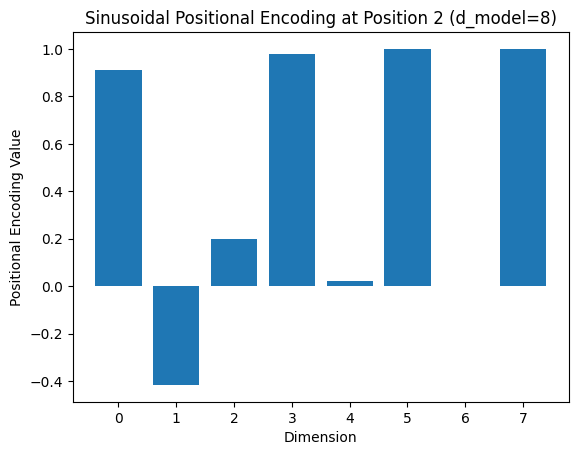

In [18]:
# let compute our example above
position = 2
d_model = 8
encoding = get_sinodial_positional_encoding(position, d_model)
print(encoding)


plt.bar(range(d_model), encoding)
plt.xlabel('Dimension')
plt.ylabel('Positional Encoding Value')
plt.title(f'Sinusoidal Positional Encoding at Position {position} (d_model={d_model})')
plt.show()


In [19]:
# lets do it for larger range of positions and embeddings
seq_len = 512
d_model = 256


positional_encodings = torch.zeros(seq_len, d_model)
for i in range(seq_len):
    positional_encodings[i] = get_sinodial_positional_encoding(i, d_model)


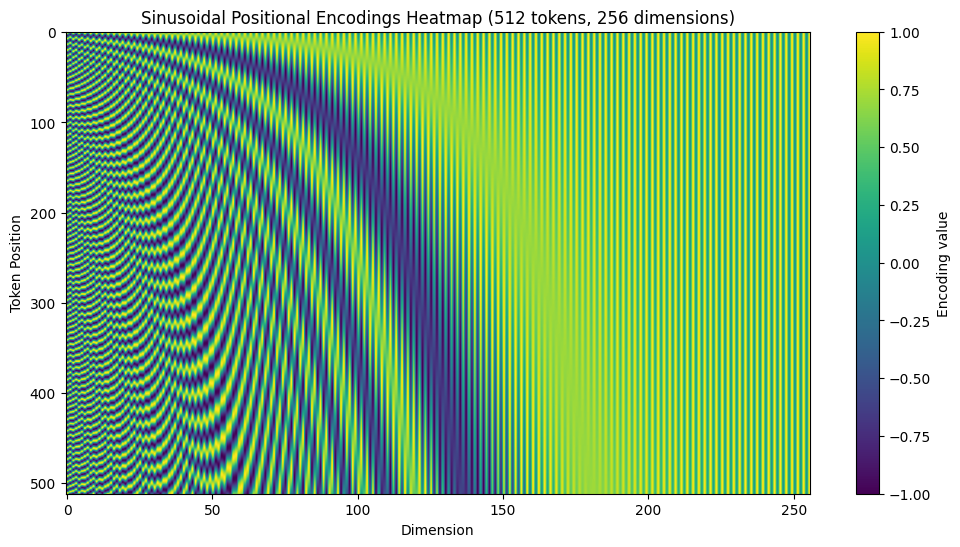

In [20]:
# Visualize a heatmap of the positional encodings matrix
plt.figure(figsize=(12, 6))
plt.imshow(positional_encodings, aspect='auto')
plt.colorbar(label='Encoding value')
plt.ylabel('Token Position')
plt.xlabel('Dimension')
plt.title(f'Sinusoidal Positional Encodings Heatmap ({seq_len} tokens, {d_model} dimensions)')
plt.show()


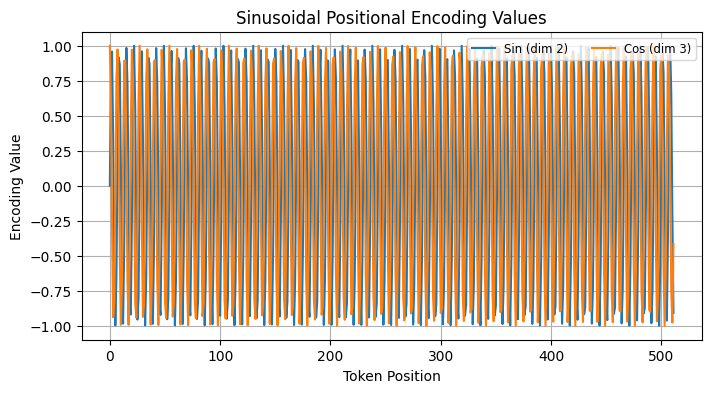

In [21]:
plot_sin_cos(positional_encodings, indices=2) #put even values 

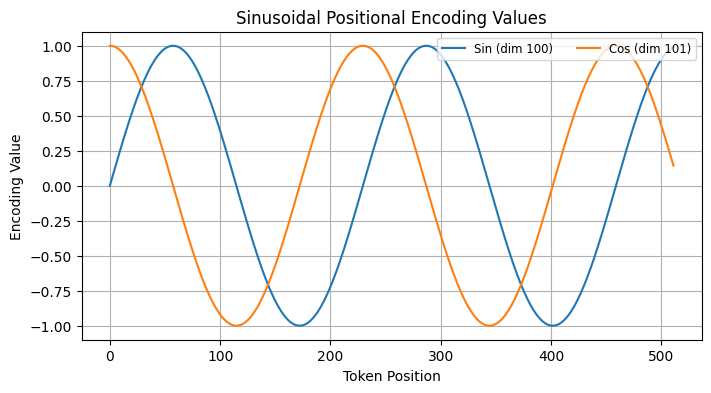

In [22]:
plot_sin_cos(positional_encodings, indices=100) #put even values 

- This heatmap visualizes the sinusoidal functions (both sine and cosine components) across all positions and embedding dimensions.
- For each dimension $i$, the sinusoidal PE varies smoothly with position, but the frequency of oscillation changes with dimension.

**The main advantage of sinusoidal embedding over binary embedding is that its positional grpahs are continous as oppose to jumpy and discrete for binary embeddings. This leads to a much stable LLM optimzation process.**

How does it keeps track of relative positiion? 

The sin and cosine function does the magic. Hence, if we know the position $P$ then we can know the $P+K$ position as well. 

Here is an example:

$$
\mathbf{v}_1 = (\cos \theta, \sin \theta)
$$

$$
\theta = \omega_i \cdot p \quad \omega_i = \frac{1}{10000^{2i/d}}
$$

$$
\mathbf{v}_2 = (\cos(\theta + \theta_1), \sin(\theta + \theta_1))
$$

$$
\theta_1 = \omega k

$$

$$
\theta + \theta_1 = \omega(p+k)
$$

for dimension position 2,3 

$$
PE(Pos, 2i) = \sin \frac{p+k}{10000^{\frac{2i}{d_{model}}}}
$$


$$
PE(Pos, 2i+1) = \cos \frac{p+k}{10000^{\frac{2i}{d_{model}}}}
$$

Hence, if we rotate vectore by $\theta_1$ we get $P+K$ position vactor.

In [ ]:
# lets code it: Just simple sinusodial PE

class SinusoidalPE:
    def __init__(self, embedding_size, max_seq_len):
        self.embedding_size = embedding_size
        self.max_seq_len = max_seq_len

    def __call__(self, x):
        positions = torch.arange(self.max_seq_len).unsqueeze(1) # (max_len, 1)
        dimensions = torch.arange(self.embedding_size).unsqueeze(0) # (1, emb_size)

        # compute freq (1/(10000 ** (2 * (dimensions // 2)) / embedding_size)
        frequencies = 1 / (10000 ** (2 * (dimensions // 2) / self.embedding_size))
        # placeholder 
        PE = torch.zeros(self.max_seq_len, self.embedding_size)

        # compute PE
        PE[:, 0::2] = torch.sin(positions * frequencies[:, 0::2])
        PE[:, 1::2] = torch.cos(positions * frequencies[:,1::2])

        return PE

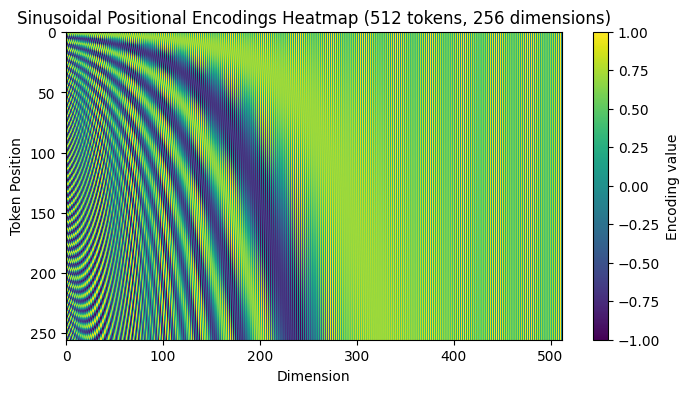

In [62]:
data = torch.rand(512, 256)
pe = SinusoidalPE(512, 256)
enc = pe(data)
# Visualize a heatmap of the positional encodings matrix
plt.figure(figsize=(8, 4))
plt.imshow(enc, aspect='auto')
plt.colorbar(label='Encoding value')
plt.ylabel('Token Position')
plt.xlabel('Dimension')
plt.title(f'Sinusoidal Positional Encodings Heatmap ({seq_len} tokens, {d_model} dimensions)')
plt.show()


#### Issues with the sinusodial positional encodings

We are still adding the positional encodings to input embedding vectors, which dilutes the semantics information carried by token embeddings. 

Take a look at the RoPE.
